# Smoothing/Interpolating and Filtering

Regardless of the experiment, noise (may also be referred to as random error) is an inevitable feature that introduces variability and "randomness" into the results. This is simply because it's impossible to completely remove or account for the source(s) that is/are causing noise. However, techniques exist that reduce noise without totally deprecating the underlying signal. Here, we will introduce the basics of smoothing/filtering and interpolating, including when and how to use them. Importantly, these techniques are typically used in combination to process a raw signal. In fact, smoothing/interpolation and filtering may be referenced interchangeably, especially with respect to functions/scripts that incorporate aspects of both.

As a quick side note, convolutions (mathematical operations performed on two input signals to generate a single output signal) are routinely used in both smoothing/interpolating and filtering. With respect to smoothing/interpolating, the Savitzky-Golay smoothing algorithm requires a final convolution on the generated coefficients (dependent on frame and degree of polynomial) and input signal. With respect to filtering, low-pass and high-pass filters can be constructed from a convolution on the appropriate impulse response and input signal (more info found [here](http://www.dspguide.com/ch6/2.htm)).

Before we really get started, run the cell below to import the necessary packages for this notebook.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import operator
#import peakutils #If you are using Google Colab, try replacing (import peakutils) with (!pip install peakutils)
!pip install peakutils
from scipy.interpolate import *
from scipy.signal import *

We will be smoothing and filtering our dataset, which is a time series Google Trends data of three key words ("diet", "gym", and "finance"). Let's focus on the Google trends of "diet" from 2004-2017.

In [ ]:
#upload the data from "https://raw.githubusercontent.com/BeaverWorksMedlytics/Week2_public/master/multiTimeline.csv"
#WRITE CODE HERE
data = pd.read_csv('https://raw.githubusercontent.com/BeaverWorksMedlytics/Week2_public/master/multiTimeline.csv', header=1)
data.head()

,month,diet,gym,finance
0,2004-01,100,31,48
1,2004-02,75,26,49
2,2004-03,67,24,47
3,2004-04,70,22,48
4,2004-05,72,22,43


The cell below stores the values and dates in numpy ndarrays. In order to smoothly plot the data further down the line, the month number is converted to a fractional component of the year. For example, 2004-02 becomes 2004.08333.

In [ ]:
values = np.ndarray(shape = (len(data['diet']),))
dates = np.ndarray(shape = (len(data['month']),))

for counter, value in enumerate(data['diet']):
    values[counter] = value 
for counter, date in enumerate(data['month']):
    temp = date.split('-')
    dates[counter] = int(temp[0]) + ((int(temp[1])-1) * 1/12)

The cell below contains a complete function for the moving average algorithm. Since this was covered in the signal processing introduction, just take several minutes to look at the code, make sense of it, and play around with the parameters.

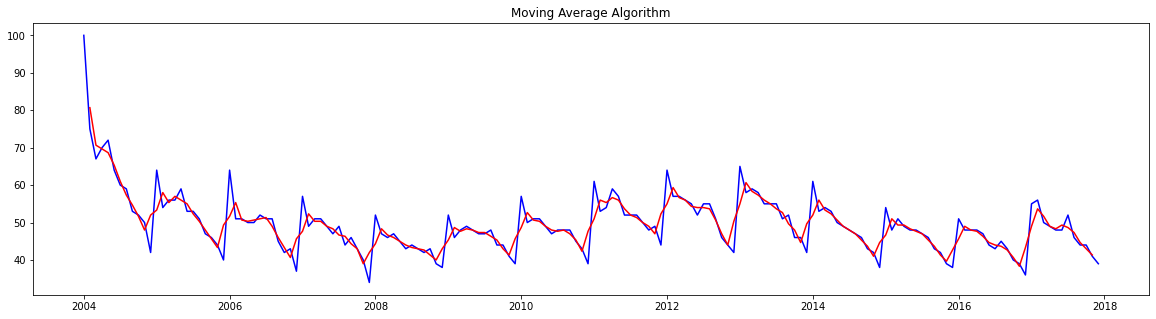

In [ ]:
#create the moving average function and implement it. Assume frame to be 3.
def moving_average(x, y, frame):
    """
    Generates new timepoints and values from the average of a moving frame.

    Parameters:
        x : list or np.array;
            Timepoints
        y : list or np.array;
            Values
        frame : int;
            Number of timepoints included in each average 

    Returns:
        x_ma : list or np.array;
            New timepoints after moving average algorithm
        y_ma : list or np.array;
            New values after moving average algorithm
    """
    # Predetermine new length of x_ma and y_ma
    #WRITE CODE HERE
    size_ma = y.shape[0]-frame+1
    y_ma = np.ndarray(shape=(size_ma,))
    x_ma = np.ndarray(shape=(size_ma,))
    for i in range(size_ma):
        # Set each y_ma value to average of frame
        #WRITE CODE HERE
        y_ma[i] = np.average(values[i:i+frame])
        # Set each x_ma to corresponding y_ma
        #WRITE CODE HERE
        if frame%2==1:
            x_ma[i] = x[(2*i+frame)//2]
        else:
            x_ma[i] = x[(2*i+frame)//2]-1/24
    # Return new timepoints and values
    #WRITE CODE HERE
    return x_ma, y_ma

dates_ma, values_ma = moving_average(dates, values, 3)

#plot the Moving Average Algorithm
#WRITE CODE HERE
plt.figure(figsize = (20, 5))
plt.title('Moving Average Algorithm')
plt.plot(dates, values, 'b')
plt.plot(dates_ma, values_ma, 'r')
plt.show()

For our filtering dataset, we are going to be looking at the superposition of three sine waves with different amplitudes and added noise. The cell below will visualize the raw and FFT data.

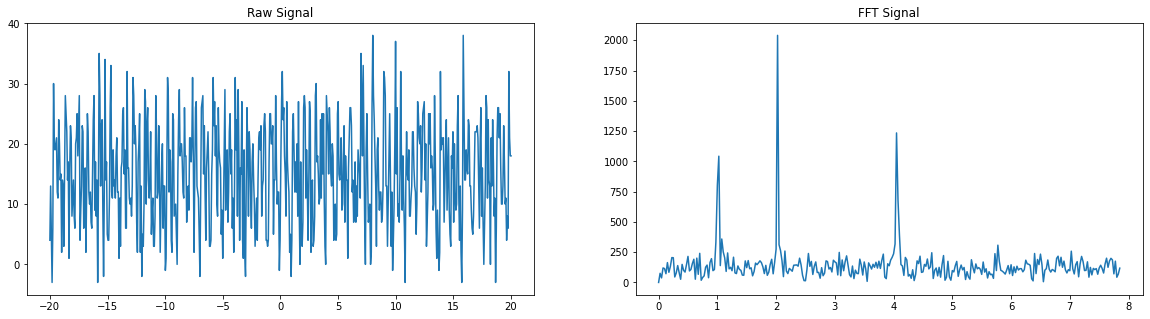

In [ ]:
x = np.linspace(-20, 20, num = int(200*np.pi))
y = [4, 13, 5, -3, 6, 30, 20, 19, 20, 21, 12, 11, 24, 20, 14, 15, 2, 14, 13, 3, 16, 28, 25, 22, 14, 17, 1, 16, 23, 21, 8, 11, 14, 8, 6, 20, 21, 25, 18, 23, 28, 4, 9, 13, 23, 22, 6, 8, 16, 2, 12, 25, 22, 12, 10, 12, 7, 6, 15, 24, 28, 9, 17, 8, 14, -3, 13, 35, 28, 13, 23, 24, 9, -2, 12, 34, 14, 17, 5, 4, 4, 11, 26, 33, 12, 11, 19, 13, 14, 11, 18, 21, 12, 12, 1, 11, 3, 16, 17, 25, 26, 15, 19, 6, 6, 32, 16, 16, 11, 10, 11, 8, 13, 31, 28, 20, 23, 19, 7, 2, 17, 20, 25, 2, 13, -2, 5, 3, 10, 29, 27, 10, 23, 26, 14, 11, 14, 22, 5, 9, 11, 3, 3, 8, 28, 22, 11, 12, 23, 14, 2, 10, 17, 20, 6, 13, 13, -1, 1, 17, 31, 28, 12, 19, 17, 4, 2, 25, 24, 8, 9, 10, 5, 0, 15, 24, 29, 18, 20, 20, 17, 12, 11, 26, 18, 18, 7, 11, 13, 9, 21, 21, 17, 20, 31, 18, 2, 15, 26, 27, 13, 12, 11, 5, -2, 11, 26, 27, 28, 15, 23, 12, 4, 16, 19, 22, 15, 3, 3, 4, 15, 19, 31, 23, 27, 18, 23, 10, 8, 26, 19, 17, 16, 5, 9, 1, 9, 19, 29, 9, 17, 19, 7, 12, 22, 25, 15, 19, 6, 11, 2, 12, 31, 19, 24, 8, 29, 18, 4, 16, 15, 27, 4, 1, 19, 2, -2, 14, 26, 19, 8, 22, 19, 11, 6, 17, 20, 14, 10, 3, 7, 11, 4, 14, 21, 22, 19, 23, 8, 13, 14, 23, 25, 22, 4, 4, 3, 4, 17, 25, 25, 20, 20, 23, 5, 14, 14, 28, 17, 10, 12, 12, -1, 4, 17, 27, 32, 24, 26, 18, 15, 8, 27, 17, 14, 12, 2, 5, -2, 4, 22, 25, 18, 12, 17, 12, 20, 8, 27, 9, 0, 17, 5, 3, 7, 26, 28, 26, 11, 19, 13, 4, 13, 27, 25, 2, 13, 14, 3, 4, 8, 28, 30, 17, 18, 15, 10, 11, 24, 11, 25, 15, 25, 11, 3, 0, 28, 25, 22, 15, 26, 22, 15, 13, 20, 18, 4, 8, 10, 4, 5, 25, 27, 15, 14, 16, 21, 9, 10, 18, 23, 7, 18, 14, 14, 1, 16, 21, 26, 26, 23, 12, 14, 7, 8, 17, 7, 13, 8, 19, 17, 15, 11, 35, 28, 18, 33, 20, 7, 0, 19, 25, 15, 7, 8, 10, 0, 2, 26, 38, 28, 24, 18, 13, 3, 19, 21, 13, 9, 12, 12, 7, 8, 13, 32, 31, 28, 13, 13, 3, 10, 18, 25, 15, 3, 12, -1, 4, 10, 20, 37, 15, 26, 8, 10, 7, 15, 32, 17, 9, 18, 11, 6, -3, 14, 22, 15, 14, 19, 8, 8, 11, 13, 22, 22, 16, 13, 12, 5, 10, 27, 25, 21, 20, 23, 12, 16, 25, 26, 27, 14, 20, 3, 7, 12, 25, 20, 25, 16, 18, 16, 9, 10, 28, 18, 6, 1, 9, 4, -1, 2, 32, 19, 21, 20, 21, 7, 13, 19, 24, 9, 15, 21, 9, 5, 3, 18, 16, 22, 7, 20, 12, 9, 10, 23, 28, 11, 4, 13, 2, -3, 9, 38, 26, 14, 14, 19, 16, 15, 24, 23, 13, 13, 9, 6, 5, 8, 15, 22, 22, 22, 23, 21, 14, 6, 20, 26, 8, 16, 7, 0, 7, 13, 28, 26, 11, 24, 14, 13, 0, 21, 13, 24, 17, 8, 11, -3, 6, 21, 26, 26, 21, 25, 16, 10, 10, 13, 23, 17, 10, 11, 4, 8, 6, 32, 21, 18, 18]

# Perform a fast fourier transform (FFT) (use np.fft.rfft()), store the new x (x_fourier) and y (y_fourier) values, and plot these new values
#WRITE CODE HERE (think about complex conjugates and remember to zero center the signal)
x_fourier = np.arange((len(x)//2)+1)/40
y_2 = y - np.mean(y)
y_fourier = np.fft.rfft(y_2)

#Compare the Raw Signal to the FFT Signal
#WRITE CODE HERE

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.title('Raw Signal')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title('FFT Signal')
''' Notes: In general, make sure to plot the absolute values of the FFT signal (for ease of visualization), 
           but retain both the positive and negative values of the FFT signal '''
plt.plot(x_fourier, np.abs(y_fourier))
plt.show()

In the cells below, you will "clean" and plot this noisy signal. In particular, you will be constructing three different types of filters: band-pass, low-pass, and high-pass. These filters are fairly simple to construct through manipulation of the fourier transform.

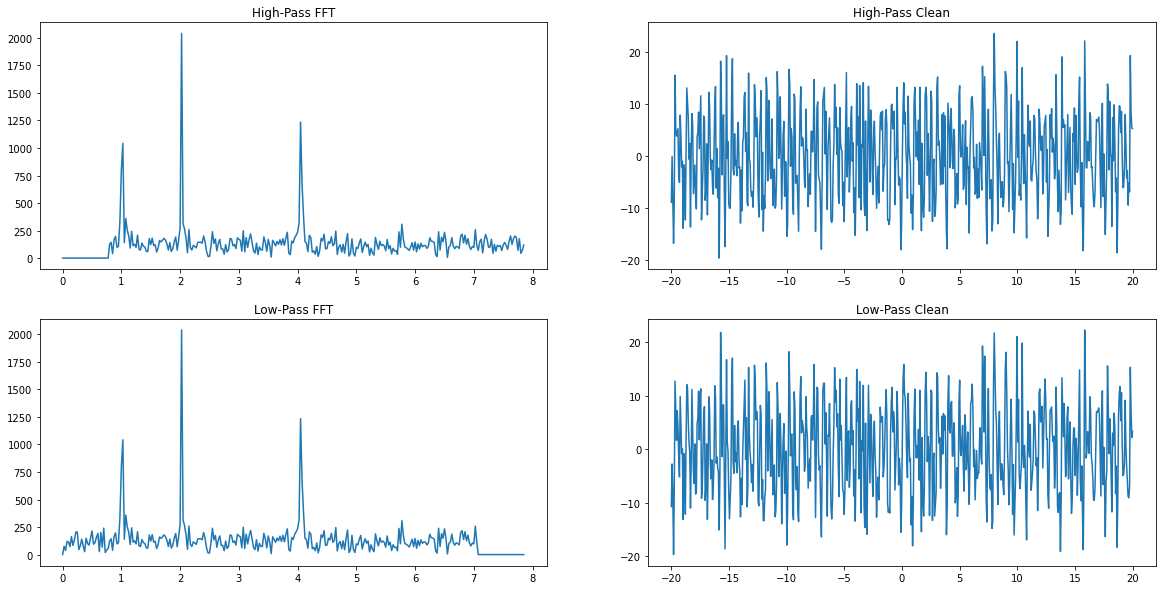

In [ ]:
def pass_filter(x_fourier, y_fourier, operator, cutoff):
    """
    Processes FFT data, keeping frequency bands higher (high-pass) or lower (low-pass) than the cutoff

    Parameters:
        x_fourier : list or np.array;
            FFT frequencies
        y_fourier : list or np.array;
            FFT amplitudes
        operator : operator.function() (https://docs.python.org/3.4/library/operator.html);
            Function used to distinguish between high-pass and low-pass filter
        cutoff : float;
            Frequency (percentage of total width of FFT frequencies) at which subsequent frequencies are passed or removed (depending on operator)

    Returns:
        y_filter : list or np.array;
            FFT amplitudes after high- or low-pass filter
    """ 
    # Create a variable named y_filter that stores a copy of y_fourier
    ''' Notes: Make sure to use np.copy or else y_filter will simply be a reference to y_fourier '''
    #WRITE CODE HERE
    y_filter = np.copy(y_fourier)
    
    # Create the filter (based on operator) and set unwelcome frequencies equal to zero
    #WRITE CODE HERE
    for count, value in enumerate(x_fourier):
        if operator(value, cutoff*np.max(x_fourier))==False:
            y_filter[count] = 0
    
    # Return new FFT values
    #WRITE CODE HERE
    return y_filter

y_high_pass = pass_filter(x_fourier, y_fourier, operator.gt, 0.1)
y_low_pass = pass_filter(x_fourier, y_fourier, operator.lt, 0.9)

plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.title('High-Pass FFT')
plt.plot(x_fourier, np.abs(y_high_pass))
plt.subplot(2, 2, 2)
plt.title('High-Pass Clean')
plt.plot(x, np.fft.irfft(y_high_pass))
plt.subplot(2, 2, 3)
plt.title('Low-Pass FFT')
plt.plot(x_fourier, np.abs(y_low_pass))
plt.subplot(2, 2, 4)
plt.title('Low-Pass Clean')
plt.plot(x, np.fft.irfft(y_low_pass))
plt.show()

In [ ]:
def band_pass_filter(x_fourier, y_fourier, band_width):
    """
    Processes FFT data, taking only frequency bands around identified peaks

    Parameters:
        x_fourier : list or np.array;
            FFT frequencies
        y_fourier : list or np.array;
            FFT amplitudes
        band_width : float;
            Width (percentage of total width of FFT frequencies) of each band

    Returns:
        y_filter : list or np.array;
            FFT amplitudes after band-pass filter
    """
    # Identify the peaks of the FFT (use peakutils.peak.indexes()) and confirm that these are reasonable peaks (through plotting)
    ''' Notes: Make sure to use np.abs(y_fourier) or else the thres parameter will pull out undesirable peaks '''
    #WRITE CODE HERE
    indexes = peakutils.peak.indexes(np.array(np.abs(y_fourier)), thres=0.35)
    x_peaks = x_fourier[indexes]
    y_peaks = y_fourier[indexes]
    
    #Plot FFT Peaks
    #WRITE CODE HERE
    plt.figure(figsize = (20, 5))
    plt.title('FFT Peaks')
    plt.plot(x_fourier, np.abs(y_fourier))
    plt.plot(x_peaks, np.abs(y_peaks), 'o')
    plt.show()

    # Filter the FFT data by taking the FFT values at each area (determined by cutoff) around a peak index while setting all other FFT values to zero
    ''' Notes: If using np.zeros, make sure to cast the data type as complex;
               Make sure to not iterate over y_fourier '''
    #WRITE CODE HERE
    y_filter = np.zeros(shape = (len(y_fourier)), dtype = complex)
    for i in indexes:
        for j in range(i-int(len(y_fourier)*band_width/2), i+int(len(y_fourier)*band_width/2)):
            ''' Notes: Ensures that j is positive since negative indices will wrap around '''
            if operator.ge(j, 0):
                y_filter[j] = y_fourier[j]
    
    # Return new FFT values
    #WRITE CODE HERE
    return y_filter

y_band_pass = band_pass_filter(x_fourier, y_fourier, 0.01)

plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.title('Band-Pass FFT')
plt.plot(x_fourier, np.abs(y_band_pass))
plt.subplot(1, 2, 2)
plt.title('Band-Pass Clean')
plt.plot(x, np.fft.irfft(y_band_pass))
plt.show()

NameError: ignored